[I 2025-03-11 17:06:43,079] A new study created in memory with name: no-name-bf381f9d-d0cd-4049-85ea-269fd1c90144
[I 2025-03-11 17:06:43,897] Trial 0 finished with value: 0.9005982632429577 and parameters: {'n_estimators': 195, 'max_depth': 3, 'learning_rate': 0.05737962258571967, 'subsample': 0.9620325133585766, 'colsample_bytree': 0.9681837854145627, 'gamma': 0.0607218508834202, 'reg_alpha': 0.29409372482720286, 'reg_lambda': 0.16910560435385327}. Best is trial 0 with value: 0.9005982632429577.
[I 2025-03-11 17:06:44,737] Trial 1 finished with value: 0.8397490882154834 and parameters: {'n_estimators': 283, 'max_depth': 2, 'learning_rate': 0.056621915512435325, 'subsample': 0.9622649065310436, 'colsample_bytree': 0.9549859471412833, 'gamma': 0.04716430105880878, 'reg_alpha': 0.1844532280837067, 'reg_lambda': 0.057357942482583}. Best is trial 0 with value: 0.9005982632429577.
[I 2025-03-11 17:06:45,628] Trial 2 finished with value: 0.8338398387199126 and parameters: {'n_estimators': 17

[I 2025-03-11 17:07:06,045] Trial 21 finished with value: 0.9314578690350196 and parameters: {'n_estimators': 279, 'max_depth': 3, 'learning_rate': 0.05403399568872754, 'subsample': 0.9825955804743305, 'colsample_bytree': 0.9719451195863411, 'gamma': 0.0344894500981023, 'reg_alpha': 0.13011160908076214, 'reg_lambda': 0.10534021115629458}. Best is trial 16 with value: 0.934866616776663.
[I 2025-03-11 17:07:07,214] Trial 22 finished with value: 0.9423506607108605 and parameters: {'n_estimators': 287, 'max_depth': 3, 'learning_rate': 0.059954561551609505, 'subsample': 0.9674587119623296, 'colsample_bytree': 0.970964266364437, 'gamma': 0.03241378528863728, 'reg_alpha': 0.11078272699555505, 'reg_lambda': 0.012274252239176678}. Best is trial 22 with value: 0.9423506607108605.
[I 2025-03-11 17:07:08,493] Trial 23 finished with value: 0.9437207938368288 and parameters: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.05978262052470279, 'subsample': 0.9665236878311868, 'colsample_bytree

Mejores hiperparámetros: {'n_estimators': 298, 'max_depth': 3, 'learning_rate': 0.05978262052470279, 'subsample': 0.9665236878311868, 'colsample_bytree': 0.9646697745358361, 'gamma': 0.024978742576409287, 'reg_alpha': 0.051419592847334876, 'reg_lambda': 0.016057599309228624}

 Evaluación en Test Set:
MSE: 0.0604 | R²: 0.9738


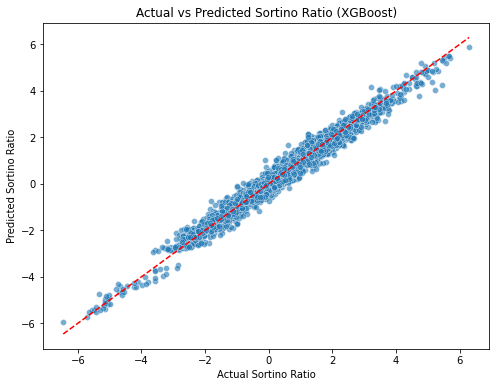

In [5]:
import optuna
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Cargar dataset
file_path = "sampled_data.csv"
df = pd.read_csv(file_path, low_memory=False)

# Preprocesamiento de datos
df = df.drop(columns=['Unnamed: 0', 'Date', 'Portfolio_Returns'])
X = df.drop(columns=['Sortino_Ratio'])
y = df['Sortino_Ratio']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en Train, Validation y Test
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 150, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 3),  
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.06),  
        'subsample': trial.suggest_float('subsample', 0.9, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.95, 1.0),
        'gamma': trial.suggest_float('gamma', 0.01, 0.1),  
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.3),  
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 0.3)
    }

    model = xgb.XGBRegressor(**params, objective='reg:squarederror')
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    # Penalizar modelos con R² demasiado alto para que no sobreajusten
    r2_mean = scores.mean()
    if r2_mean > 0.95:
        return 0.95 - r2_mean  # Penalización
    return r2_mean  # Optimiza dentro del rango deseado

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Mejores hiperparámetros:", study.best_params)

best_model = xgb.XGBRegressor(**best_params, objective='reg:squarederror')
best_model.fit(X_train, y_train)

preds = best_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n Evaluación en Test Set:\nMSE: {mse:.4f} | R²: {r2:.4f}")

results_df = pd.DataFrame({'Actual': y_test, 'Predicted': preds})
plt.figure(figsize=(8, 6))
sns.scatterplot(x=results_df["Actual"], y=results_df["Predicted"], alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sortino Ratio")
plt.ylabel("Predicted Sortino Ratio")
plt.title("Actual vs Predicted Sortino Ratio (XGBoost)")
plt.show()


In [3]:
# Implementación del mejor modelo XGBoost optimizado
xgb_model = xgb.XGBRegressor(
    n_estimators=520, 
    max_depth=5, 
    learning_rate=0.09967787501548325,
    subsample=0.7831340192834264,
    colsample_bytree=0.89,
    gamma=0.013473933415560075,
    reg_alpha=0.900012432370921,
    reg_lambda=0.5683957654703357,
    objective='reg:squarederror'
)

xgb_model.fit(X_train, y_train)

preds = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print("\n Evaluación Final del Modelo XGBoost Optimizado:")
print(f"MSE: {mse:.4f} | R²: {r2:.4f}")


NameError: name 'X_train' is not defined

In [15]:
import pickle

with open("xgboost_optimized.pkl", "wb") as file: 
    pickle.dump(xgb_model,file)